# Indice:

* [Intro](#Intro)
    - [Osservazione 1](#Oss1)
* [Step 1 - creazione e studio primi modelli](#Step1)
* [Step 2 - validazione di alpha e cancellazione features](#Step2)
* [Step 3 - nuovi modelli con meno features](#Step3)
    - [Osservazione 2](#Oss2)
* [Step 4 - confronto grafico](#Step4)
* [Conclusione](#Conclusione)
* [Bonus - SVR](#Bonus)

## Intro

Scopo del progetto è addestrare un singolo modello di apprendimento e descriverne le performance.
Il dataset scelto è "diabates", dove il nostro target è una variabile continua che rappresenta una misura quantitativa della progressione del diabete.
Useremo, quindi, un modello di regressione. Il modello scelto è la **regressione lineare**.

P.S. ho deciso di scegliere questo modello pur essendo in dubbio tra questo ed il regression tree. Per curiosità allego anche un notebook con il RT.

In [1]:
# Importo tutti i pacchetti
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.svm import SVR
from tabulate import tabulate

In [2]:
# Importo i dati e ne stampo la descrizione
diabetes = datasets.load_diabetes()
print(diabetes['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [3]:
# Accedo ai dati e controllo la grandezza di ciascuno
X = diabetes['data']
y = diabetes['target']

print(X.shape, y.shape)

(442, 10) (442,)


In [4]:
# Creo un dataframe unico
df = pd.DataFrame(X, y)
df.reset_index(inplace=True)
df.rename(columns={'index': 'diabetes'}, inplace=True)

name = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
# Rinomino i vari campi
rename_dict = dict()
for i, x in enumerate(name):
    rename_dict.update({i: x})
    
df.rename(columns=rename_dict, inplace=True)
df.head()

,diabetes,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,151.0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,75.0,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,141.0,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,206.0,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,135.0,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


<AxesSubplot:title={'center':'Correlation between dataset variables'}>

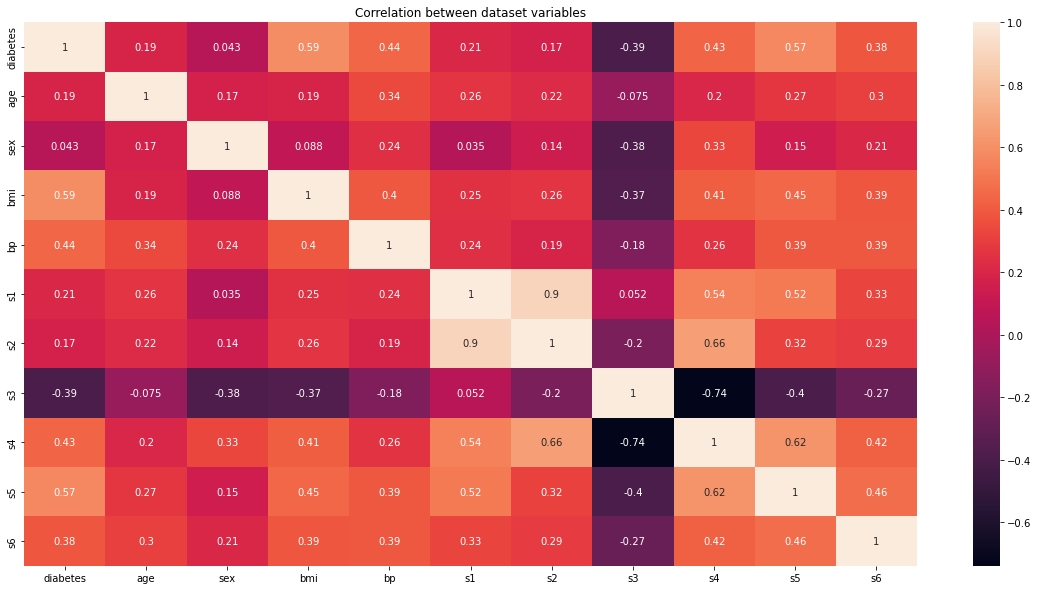

In [5]:
# Faccio un check su eventuale presenza di correlazione tra le variabili
plt.figure(figsize=(20,10))
plt.title('Correlation between dataset variables')
sns.heatmap(df.corr(), annot=True)

#### Osservazione 1
<a id="Oss1"></a>

La mappa di correlazione ci fa notare lo stretto rapporto lineare che sussiste tra *s1* ed *s2*, ma anche tra *s3* ed *s4*.
Ciò ci farebbe pensare che potremmo scartare due di queste variabili per il nostro modello.
Per ora, però, teniamo da parte queste osservazioni e procediamo.

------------------------------

Cerchiamo, invece, di capire come varia il livello di diabete al variare dell'età e del sesso.
Dato la bassa correlazione ci aspettiamo di non vedere particolari legami.

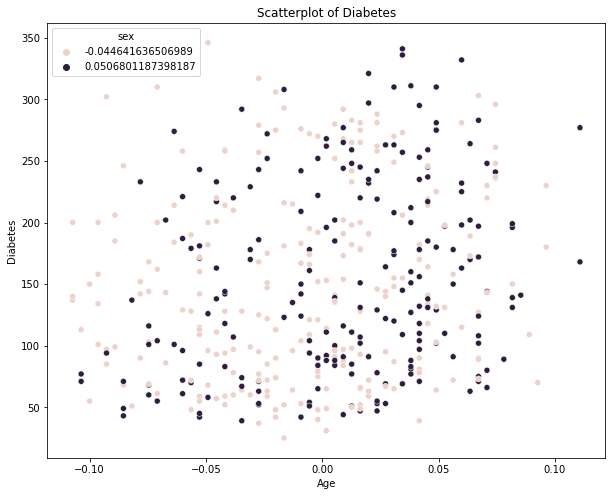

In [6]:
# Sesso ed età influenzano il livello di diabete?
plt.figure(figsize=(10,8))
sns.scatterplot(x='age', y='diabetes', hue='sex', data=df)
plt.title('Scatterplot of Diabetes')
plt.xlabel("Age")
plt.ylabel("Diabetes")
plt.show()

Lo scatterplot conferma le nostre ipotesi. Non solo non vi è una correlazione con l'età ma maschi e femmine sembrano equamente distribuiti.

-------------

## Step 1 - creazione e studio primi modelli
<a id="Step1"></a>

Iniziamo a creare i primi modelli.

In [7]:
# Splitto i dati in train e test
df2 = df.drop('diabetes', axis=1)
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.33, random_state=42)

In [8]:
# Questa tabella ci tornerà utile per il "confrontone" finale
table = {"Model": [], "R2_score": [], "MAE": [], "MSE": []}

# Un'utile funzione che richiameremo più volte!
def print_error(model, train, test, model_name):
    """a quick function that prints r2_score, MAE, MSE, mean_accuracy and std
       it also add relative value to the table 
    """
    pred = model.predict(test)
    print(f"r2_score: {model.score(test, y_test)}, MAE: {mean_absolute_error(pred, y_test)}, MSE: {mean_squared_error(pred, y_test)}")
    table["Model"].append(model_name)
    table["R2_score"].append(model.score(test, y_test))
    table["MAE"].append(mean_absolute_error(pred, y_test))
    table["MSE"].append(mean_squared_error(pred, y_test))
    scores = cross_val_score(model, train, y_train, cv=5)
    print("Cross-Validation: %0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

In [9]:
# Regressione lineare "semplice" con tutti e 10 i parametri
regr = LinearRegression()
regr.fit(X_train, y_train)
print_error(regr, X_train, X_test, "LinearRegression")

r2_score: 0.5103954261351442, MAE: 41.964453026532645, MSE: 2817.8015701686763
Cross-Validation: 0.4520 accuracy with a standard deviation of 0.1133


Tramite la *linear regression* abbiamo ottenuto un discreto punteggio.
Ci chiediamo però se:
* Si può migliorare questo modello?
* Sono necessarie tutte e 10 le feature?
* Come validiamo le nostre scelte?

--------------

Ci viene in aiuto in questo caso la **Lasso Regression**. Questo modello ha il vantaggio di azzerare i coefficienti delle feature meno "importanti"!

In [10]:
# Passo ad un Lasso Regression per capire quali feature è possibile non considerare
lasso = Lasso(random_state=0)
lasso.fit(X_train, y_train)

for i, col in enumerate(name):
    print(f"Coeff. of {col}: \t {lasso.coef_[i]}")

print(f"Intercept: {lasso.intercept_}")

Coeff. of age: 	 0.0
Coeff. of sex: 	 -0.0
Coeff. of bmi: 	 425.8946195702991
Coeff. of bp: 	 69.18843584604996
Coeff. of s1: 	 0.0
Coeff. of s2: 	 0.0
Coeff. of s3: 	 -0.0
Coeff. of s4: 	 0.0
Coeff. of s5: 	 177.77583411452272
Coeff. of s6: 	 0.0
Intercept: 150.97739174702443


In [11]:
# è un buon modello?
print_error(lasso, X_train, X_test, "Lasso 'simple'")

r2_score: 0.3624694905902398, MAE: 51.05951018284622, MSE: 3669.1537749831627
Cross-Validation: 0.3106 accuracy with a standard deviation of 0.0546


Tramite uno studio preliminare sembrerebbe che 7 feature su 10 non abbiano praticamente peso.
I vari punteggi però ci mettono in allerta sul fatto che potrebbe non essere il modello ottimale da considerare.

-------------------

## Step 2 - validazione di alpha e cancellazione features
<a id="Step2"></a>

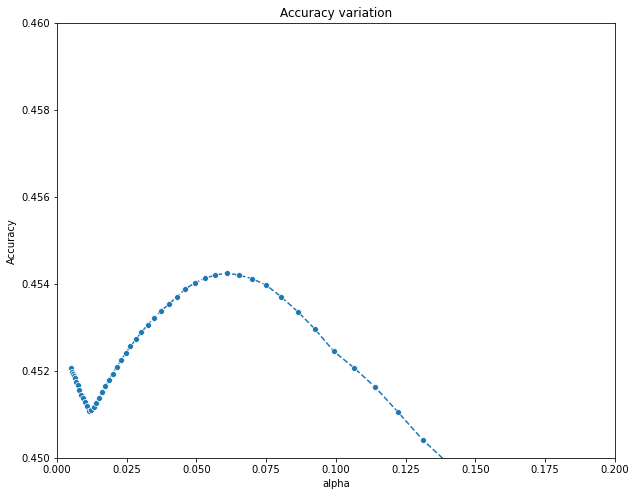

In [12]:
# Estraggo tutti gli alpha su cui testare il modello
path = lasso.path(X_train, y_train)
alphas = path[0]
alpha_values = []
# Cerco l'alpha ottimale tramite cross-validation
for i in alphas:
    lasso = Lasso(alpha=i, random_state=0)
    scores = cross_val_score(lasso, X_train, y_train, cv=5)
    alpha_values.append([i, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'mean_acc', 'std'])
# Plot Accuracy vs alpha
plt.figure(figsize=(10,8))
sns.lineplot(x='alpha', y='mean_acc', marker='o', linestyle='--', data=alpha_results)
plt.xlim([0, 0.2]) # 'zoom' sui valori più importanti
plt.ylim([0.45, 0.46])
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy variation")
# Salvo dentro una variabile l'alpha ottimale
max_mean = alpha_results['mean_acc'].max(axis=0)
opt_alpha = float(alpha_results[alpha_results['mean_acc'] == max_mean]['alpha'])

In [13]:
# Lasso Regression, questa volta con alpha ottimale
lasso_opt_alpha = Lasso(alpha=opt_alpha, random_state=0)
lasso_opt_alpha.fit(X_train, y_train)

for i, col in enumerate(name):
    print(f"Coeff. of {col}: \t {lasso_opt_alpha.coef_[i]}")
    
print(f"Intercept: {lasso_opt_alpha.intercept_}")

Coeff. of age: 	 0.20027932881344068
Coeff. of sex: 	 -186.39040107735198
Coeff. of bmi: 	 565.1901850737975
Coeff. of bp: 	 374.66047592555503
Coeff. of s1: 	 -110.08570991542706
Coeff. of s2: 	 -0.0
Coeff. of s3: 	 -256.88060240410186
Coeff. of s4: 	 0.0
Coeff. of s5: 	 406.59060774376104
Coeff. of s6: 	 0.0
Intercept: 150.37451972020472


In [14]:
print_error(lasso_opt_alpha, X_train, X_test, "Lasso opt_alpha")

r2_score: 0.5115190332343285, MAE: 42.26196601196447, MSE: 2811.334919288883
Cross-Validation: 0.4542 accuracy with a standard deviation of 0.1090


Questa volta abbiamo ottenuto punteggi sicuramente più "incoraggianti". Possiamo quindi escludere 4 feature:
* s2, s4 (confermano le nostre ipotesi iniziali) ed s6 poiché coefficiente pari a 0;
* age poiché coefficiente molto vicino a 0 (conferma quanto visto dallo scatterplot), soprattutto paragonato alla grandezza degli altri.

In [15]:
# Drop delle relative feature
D_train = X_train.drop(['age', 's2', 's4', 's6'], axis=1)
D_test = X_test.drop(['age', 's2', 's4', 's6'], axis=1)
df3 = df2.drop(['age', 's2', 's4', 's6'], axis=1)

## Step 3 - nuovi modelli con meno features
<a id="Step3"></a>

In [16]:
# Riproviamo entrambe le regressioni con le 4 features in meno

# Linear
regr_opt = LinearRegression()
regr_opt.fit(D_train, y_train)
print_error(regr_opt, D_train, D_test, "LinearRegression 'dropped'")

r2_score: 0.509630857832899, MAE: 42.238276860295414, MSE: 2822.201859458381
Cross-Validation: 0.4588 accuracy with a standard deviation of 0.1069


In [17]:
# Lasso 
lasso_opt = Lasso(alpha=opt_alpha, random_state=0)
lasso_opt.fit(D_train, y_train)

new_name = ['sex', 'bmi', 'bp', 's1', 's3', 's5']

for i, col in enumerate(new_name):
    print(f"Coeff. of {col}: \t {lasso_opt.coef_[i]}")
    
print(f"Intercept: {lasso_opt.intercept_}")

Coeff. of sex: 	 -186.34743109929684
Coeff. of bmi: 	 565.2167094199939
Coeff. of bp: 	 374.695394846771
Coeff. of s1: 	 -110.08755771579212
Coeff. of s3: 	 -256.8349971682502
Coeff. of s5: 	 406.63034637512254
Intercept: 150.37461312484072


In [18]:
print_error(lasso_opt, D_train, D_test, "Lasso 'dropped'")

r2_score: 0.5115268866576652, MAE: 42.2619430443889, MSE: 2811.2897207964857
Cross-Validation: 0.4568 accuracy with a standard deviation of 0.1072


#### Osservazione 2
<a id="Oss2"></a>

Ha senso chiedersi se tramite una **Ridge Regression** è possibile ulteriormente migliorare i nostri risultati.
Il vantaggio di questa regolarizzazione è che riesce ad essere più efficace nel momento in cui tiene in considerazione le feature più importanti.

In [19]:
# Ridge Regression con le features più significative
ridge = Ridge()
ridge.fit(D_train, y_train)
print_error(ridge, D_train, D_test, "Ridge 'dropped'")

r2_score: 0.423549579434887, MAE: 47.46740411047593, MSE: 3317.6219890485063
Cross-Validation: 0.3432 accuracy with a standard deviation of 0.0705


Anche qui, cerchiamo il miglior alpha tramite CV

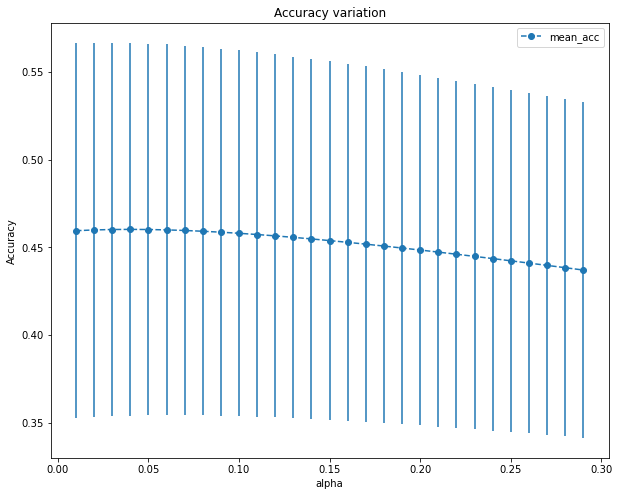

In [20]:
# Cerco l'alpha ottimale
rng = np.arange(0.01, 0.3, 0.01) # 'zoom' sui valori più efficaci
alpha_values = []

for i in rng:
    ridge = Ridge(alpha=i, random_state=0)
    scores = cross_val_score(ridge, D_train, y_train, cv=5)
    alpha_values.append([i, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'mean_acc', 'std'])


alpha_results.plot(x='alpha', y='mean_acc', yerr='std', marker='o', linestyle='--', figsize=(10,8))
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy variation")

max_mean = alpha_results['mean_acc'].max(axis=0)
opt_alpha = float(alpha_results[alpha_results['mean_acc'] == max_mean]['alpha'])

In [21]:
# Ridge con alpha ottimale
ridge_opt = Ridge(alpha=opt_alpha)
ridge_opt.fit(D_train, y_train)
print_error(ridge_opt, D_train, D_test, "Ridge opt_alpha")

r2_score: 0.51096644042669, MAE: 42.191773351121896, MSE: 2814.515234514976
Cross-Validation: 0.4602 accuracy with a standard deviation of 0.1063


## Step 4 - confronto grafico
<a id="Step4"></a>

Poiché sarebbe "difficile" fare un grafico in 8/9 dimensioni, per avere un'idea graficamente sulla bontà delle nostre previsioni cioò che faremo è:
* Assegnare all'asse X i valori del modello;
* All'asse Y i valori reali;
* Scatterplot dei modelli Ridge e Lasso.

Così facendo, la "correttezza" si misurerà dalla distanza che ciascun punto avrà dalla bisettrice (ovvero: y=x, retta dove starebbero tutti i punti se valori 'predittati' e reali coincidessero)!

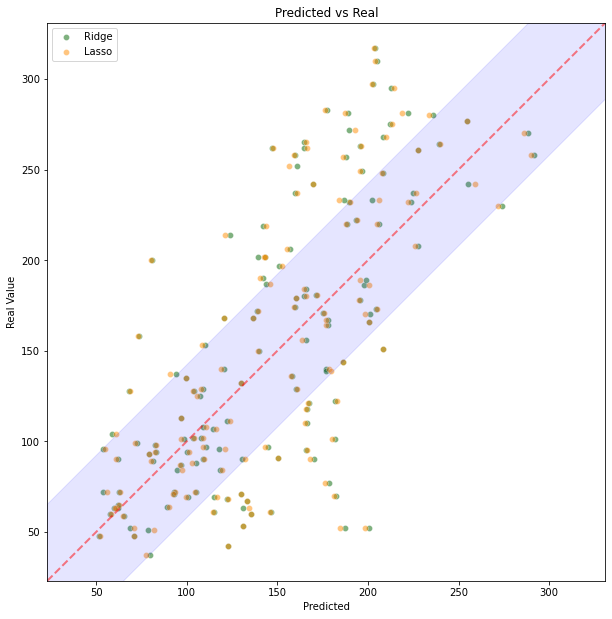

In [22]:
# Ri-predico i valori
pred1 = ridge_opt.predict(D_test)
pred2 = lasso_opt.predict(D_test)
# Scelgo il minor MAE
mae = mean_absolute_error(pred1, y_test)

# Scatterplot delle due predizioni
fig, ax = plt.subplots(figsize=(10,15))
sns.scatterplot(x=pred1, y=y_test, ax=ax, color="darkgreen", alpha=0.5, label="Ridge")
sns.scatterplot(x=pred2, y=y_test, ax=ax, color="darkorange", alpha=0.5, label="Lasso")
# Confronto con la retta y=x
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# Faccio un "fill" dell'area compresa tra +-MAE
lims_shift_dx = [
    np.min([ax.get_xlim(), ax.get_ylim()])+mae,  
    np.max([ax.get_xlim(), ax.get_ylim()])+mae,  
]

lims_shift_sx = [
    np.min([ax.get_xlim(), ax.get_ylim()])-mae,  
    np.max([ax.get_xlim(), ax.get_ylim()])-mae,  
]

ax.plot(lims, lims, color='red', linewidth=2, alpha=0.5, linestyle='--')
ax.fill_between(lims, lims_shift_sx, lims_shift_dx, edgecolor='none',
                 color='blue', alpha=0.1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Predicted")
ax.set_ylabel("Real Value")
ax.set_title("Predicted vs Real")
ax.legend()
plt.show()

Vediamo - infine - una tabella riassuntiva con tutti i modelli e i punteggi fin qui ottenuti.

In [23]:
print(tabulate(table, headers='keys', tablefmt='fancy_grid'))

╒════════════════════════════╤════════════╤═════════╤═════════╕
│ Model                      │   R2_score │     MAE │     MSE │
╞════════════════════════════╪════════════╪═════════╪═════════╡
│ LinearRegression           │   0.510395 │ 41.9645 │ 2817.8  │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ Lasso 'simple'             │   0.362469 │ 51.0595 │ 3669.15 │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ Lasso opt_alpha            │   0.511519 │ 42.262  │ 2811.33 │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ LinearRegression 'dropped' │   0.509631 │ 42.2383 │ 2822.2  │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ Lasso 'dropped'            │   0.511527 │ 42.2619 │ 2811.29 │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ Ridge 'dropped'            │   0.42355  │ 47.4674 │ 3317.62 │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ Ridge opt_alpha            │   0.51096

## Conclusione
<a id="Conclusione"></a>

Molto probabilmente la regressione lineare non è tra i modelli migliori per lo studio di questo dataset.
Le molte features che entrano in gioco rendono molto "laborioso" tutto il processo.
Nonostante ciò, tramite alcuni accorgimenti, abbiamo ottenuto risultati leggermente migliori!

## Bonus - SVR
<a id="Bonus"></a>

Si possono ottenere stime migliori tramite un SVR? Proviamoci (alla "veloce")!

In [24]:
# Setto i diversi parametri da studiare
rngC = np.arange(20, 30)
rngE = np.arange(0.01, 0.15, 0.01)
rngG = np.arange(40, 55)

for c in rngC:
    for e in rngE:
        for g in rngG:
            svr = SVR(C=c, gamma=g, epsilon=e)
            model = svr.fit(D_train, y_train)
            if model.score(D_test, y_test) >= 0.55115:
                print("C:", c, "epsilon:", e, "g:", g, "\t r2_score:", model.score(D_test, y_test))

C: 25 epsilon: 0.01 g: 51 	 r2_score: 0.5511607333269146
C: 25 epsilon: 0.02 g: 51 	 r2_score: 0.5511581663863739
C: 25 epsilon: 0.03 g: 51 	 r2_score: 0.5511557860007265
C: 25 epsilon: 0.04 g: 51 	 r2_score: 0.5511525701258145


In [25]:
# Scelgo quello con R2_score migliore
svr = SVR(C=25, gamma=51, epsilon=0.01).fit(D_train, y_train)

print_error(svr, D_train, D_test, 'SVR')

r2_score: 0.5511607333269146, MAE: 39.28263788758988, MSE: 2583.186632431011
Cross-Validation: 0.3990 accuracy with a standard deviation of 0.1214


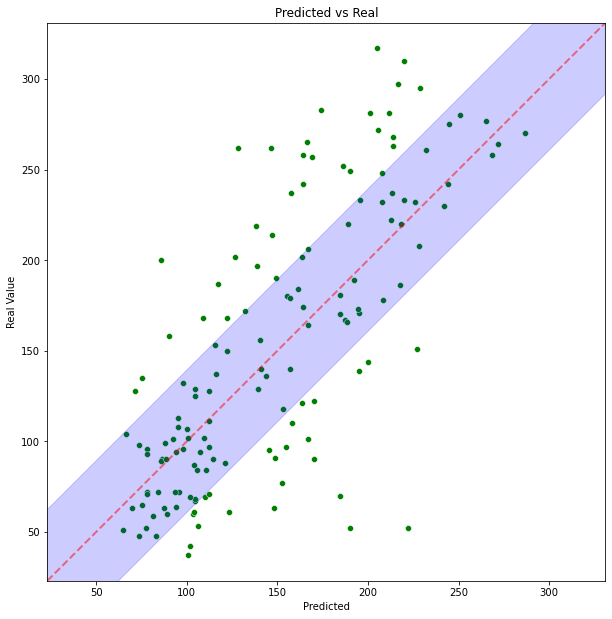

In [26]:
# Plot del modello
pred = svr.predict(D_test)
mae = mean_absolute_error(pred, y_test)

fig, ax = plt.subplots(figsize=(10,15))
sns.scatterplot(x=pred, y=y_test, ax=ax, color="green")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]

lims_shift_dx = [
    np.min([ax.get_xlim(), ax.get_ylim()])+mae,  
    np.max([ax.get_xlim(), ax.get_ylim()])+mae,  
]

lims_shift_sx = [
    np.min([ax.get_xlim(), ax.get_ylim()])-mae,  
    np.max([ax.get_xlim(), ax.get_ylim()])-mae,  
]


ax.plot(lims, lims, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax.fill_between(lims, lims_shift_sx, lims_shift_dx, edgecolor='none',
                 color='blue', alpha=0.2)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Predicted")
ax.set_ylabel("Real Value")
ax.set_title("Predicted vs Real")
plt.show()

In [27]:
# Confronto con la regressione lineare
print(tabulate(table, headers='keys', tablefmt='fancy_grid'))

╒════════════════════════════╤════════════╤═════════╤═════════╕
│ Model                      │   R2_score │     MAE │     MSE │
╞════════════════════════════╪════════════╪═════════╪═════════╡
│ LinearRegression           │   0.510395 │ 41.9645 │ 2817.8  │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ Lasso 'simple'             │   0.362469 │ 51.0595 │ 3669.15 │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ Lasso opt_alpha            │   0.511519 │ 42.262  │ 2811.33 │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ LinearRegression 'dropped' │   0.509631 │ 42.2383 │ 2822.2  │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ Lasso 'dropped'            │   0.511527 │ 42.2619 │ 2811.29 │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ Ridge 'dropped'            │   0.42355  │ 47.4674 │ 3317.62 │
├────────────────────────────┼────────────┼─────────┼─────────┤
│ Ridge opt_alpha            │   0.51096

I risultati ci dicono che, effettivamente, con il SVR riusciamo ad ottenere risultati migliori!